In [1]:
import numpy as np
import torch
import os 

import matplotlib
import matplotlib.pyplot as plt


# import corner
import seaborn as sns
sns.set()

In [2]:
print(os.getcwd())

c:\Users\ja.borowski\Documents\deconv\density-deconvolution-astro\notebooks


In [3]:
import sys
sys.path.append("c:\\Users\\ja.borowski\\Documents\\deconv\\density-deconvolution-astro\\")


In [4]:
device = torch.device("cpu")

# Create data

In [5]:
means = torch.Tensor([
    [0.0, 0.0],
    [2, 3],
    [2, -3]
])
covars = torch.Tensor([
    [
        [0.1, 0],
        [0, 1.5]
    ],
    [
        [1, 0],
        [0, 0.1]
    ],
    [
        [1, 0],
        [0, 0.1]
    ]
])

Z = torch.distributions.MultivariateNormal(loc=means, covariance_matrix=covars).sample((10000,)).reshape((-1, 2))

In [6]:
idx = torch.randperm(Z.shape[0])
Z = Z[idx]
Z_train = Z[:Z.shape[0] // 2]
Z_test = Z[Z.shape[0] // 2:]



# Add error

In [7]:
S = torch.Tensor([
    [0.1, 0],
    [0, 3]
])
X = Z + torch.distributions.MultivariateNormal(loc=torch.Tensor([0.0, 0.0]), covariance_matrix=S).sample((Z.shape[0],))
X_train = X[:X.shape[0] // 2]
X_test = X[X.shape[0] // 2:]



# Train 

In [8]:
from deconv.gmm.data import DeconvDataset

train_data = DeconvDataset(X_train, torch.linalg.cholesky(S.repeat(X_train.shape[0], 1, 1)))
test_data = DeconvDataset(X_test, torch.linalg.cholesky(S.repeat(X_test.shape[0], 1, 1)))

In [9]:
# from deconv.gmm.sgd_deconv_gmm import SGDDeconvGMM

# gmm = SGDDeconvGMM(
#     3,
#     2,
#     batch_size=200,
#     lr=1e-1,
#     epochs=100,
#     #device=torch.device('cpu')
# )
# gmm.fit(train_data, verbose=True)

In [10]:
# S.shape

In [19]:
from deconv.flow.svi import SVIFlow

svi = SVIFlow(
    2,
    5,
    device=torch.device("cpu"),
    batch_size=1000,
    epochs=20,
    lr=1e-4,
    n_samples=50,
    use_iwae=True
)

In [20]:
%%time
svi.fit(train_data, val_data=None)
torch.set_default_tensor_type('torch.FloatTensor')



Epoch 0, Train Loss: -11.7118283203125
Epoch 1, Train Loss: -6.0381539388020835
Epoch 2, Train Loss: -5.484257682291667
Epoch 3, Train Loss: -5.1410354817708335
Epoch 4, Train Loss: -4.891824967447917
Epoch 5, Train Loss: -4.663186686197917
Epoch 6, Train Loss: -4.419539876302084
Epoch 7, Train Loss: -4.265937825520833
Epoch 8, Train Loss: -4.217412760416667
Epoch 9, Train Loss: -4.19112216796875
Epoch 10, Train Loss: -4.18272880859375
Epoch 11, Train Loss: -4.1743958333333335
Epoch 12, Train Loss: -4.172768587239584
Epoch 13, Train Loss: -4.168663606770833
Epoch 14, Train Loss: -4.164873111979166
Epoch 15, Train Loss: -4.16284326171875
Epoch 16, Train Loss: -4.158644759114583
Epoch 17, Train Loss: -4.16108583984375
Epoch 18, Train Loss: -4.158961653645833
Epoch 19, Train Loss: -4.156626985677083
CPU times: total: 50min 10s
Wall time: 33min 45s


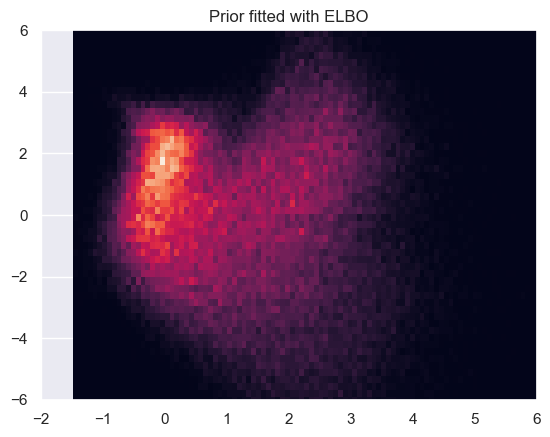

In [21]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.set_default_tensor_type('torch.FloatTensor')
prior_samples = svi.sample_prior(100_000)

fig, ax = plt.subplots()
plt.hist2d(prior_samples[0, :, 0].numpy(), prior_samples[0, :, 1].numpy(), bins=100) #, ax=ax)
x_lim = (-2, 6)
y_lim = (-6, 6)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title('Prior fitted with ELBO');

In [14]:
mean = np.array([[3.0, 0.0], [0.0, 0.0]])
cov = np.array([
    [
        [0.1, 0],
        [0, 3]
    ],
    [
        [0.1, 0],
        [0, 3]
    ]
])
test_point = [
    torch.Tensor(mean).to(svi.device),
    torch.cholesky(torch.Tensor(cov)).to(svi.device)
]
torch.set_default_tensor_type('torch.FloatTensor')
posterior_samples = svi.resample_posterior(test_point, 10000)

from deconv.gmm.plotting import plot_covariance
fig, ax = plt.subplots()
plt.hist2d(posterior_samples[0, :, 0].numpy(), posterior_samples[0, :, 1].numpy(), ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plot_covariance(
    mean[0],
    cov[0],
    ax=ax,
    color='r'
)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title('Recognition network samples for test point, fitted using ELBO.');

C:\Users\ja.borowski\AppData\Local\Temp\ipykernel_24668\2872830058.py:14: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:1703.)
  torch.cholesky(torch.Tensor(cov)).to(svi.device)


TypeError: object of type 'generator' has no len()

In [ ]:
rsamples = svi.resample_posterior(test_point, 10_000)

fig, ax = plt.subplots()
corner.hist2d(rsamples[0, :, 0].cpu().numpy(), rsamples[0, :, 1].cpu().numpy(), ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plot_covariance(
    mean[0],
    cov[0],
    ax=ax,
    color='r'
)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title('Resampled posterior for test point, fitted using ELBO.')

TypeError: object of type 'generator' has no len()

In [ ]:
importance = best_model.steps[1][1].feature_importances_
feature_names = X_train.columns

forest_importances = pd.Series(importance, index=feature_names)
# sort list of importances
sorted_importances = forest_importances.sort_values()
plt.bar(feature_names,importance)

# leve only features with importance > 0.01
to_keep = sorted_importances[sorted_importances > 0.01].index
X_train = X_train[to_keep]


NameError: name 'best_model' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score


f1_scorer = make_scorer(f1_score, average='macro')

pipeline = Pipeline([
        ('preproc', preproc),
        # add featrue selection 
        # ('feature_selection', SelectFromModel(RandomForestClassifier())),
        ('model', RandomForestClassifier(sc))
    ])
# calcuate f1 score using defaind scorer
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=f1_scorer)


# now remove features with low importance
# using score importance from a model 
# that was trained on all features
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

# create a pipeline 
pipeline = Pipeline([
        ('preproc', preproc),
        # add featrue selection 
        ('feature_selection', SelectFromModel(RandomForestClassifier())),
        ('model', RandomForestClassifier())
    ])
#get items from class 1 in training data 
